# Q-learning

## Импорты и базовые настройки

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
import gymnasium as gym
import pandas as pd

%matplotlib inline

## Softmax policy

Политика softmax означает, что вероятности действий вычисляются из q-значений с помощью функции softmax, где $\tau$ — температура softmax 

$$ \pi(a_i \mid s) = \operatorname{softmax} \left( \left\{ {Q(s, a_j) \over \tau} \right\}_{j=1}^n \right)_i = {\operatorname{exp} \left( Q(s,a_i) / \tau \right)  \over {\sum_{j}  \operatorname{exp} \left( Q(s,a_j) / \tau  \right)}} $$

Температура в softmax регулирует exploration и exploitation. Высокая температура стимулирует исследование нового (exploration), а низкая делает выбор более жадным.

Показатель степени для больших значений может быть слишком велик, чтобы поместиться в float. Для обеспечения численной устойчивости вычитаем максимум.

In [2]:
def my_softmax(values: np.ndarray, T=1.):
    """
    Вычисляет softmax вероятности на основе Q-values.

    Args:
        values: массив значений Q(s, a)
        T: softmax temperature (lower -> greedier)

    Returns:
        probas: Распределение вероятностей
    """
    probas = (np.exp(values / T - max(values / T ))) / np.sum(np.exp(values / T - max(values / T )))
    return probas

## Q-Learning Agent

In [3]:
class QLearningAgent:
    def __init__(self, alpha, discount, get_legal_actions, temp=1.):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html

        Агент обучает action-value функцию Q(s, a) в табличном виде и
        использует softmax-политику для выбора действий.

        Args:
          - self.alpha — коэффициент обучения (learning rate)
          - self.discount — коэффициент дисконтирования (gamma)
          - self.temp — температура softmax-политики (управляет exploration)

        Функции:
          - self.get_legal_actions(state)
            Принимает состояние (хешируемое) и возвращает список допустимых действий
          - self.get_qvalue(state, action)
            Возвращает значение Q(s, a)
          - self.set_qvalue(state, action, value)
            Устанавливает значение Q(s, a)
            
        !!!Important!!!
        Не рекомендуется обращаться к self._qvalues напрямую.
        Для доступа и обновления Q-значений следует использовать
        get_qvalue / set_qvalue, чтобы логика агента оставалась инкапсулированной.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.discount = discount
        self.temp = temp

    def get_qvalue(self, state, action):
        """Возвращает значение Q(s, a) для заданного состояния и действия."""
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """Устанавливает значение Q(s, a) для заданного состояния и действия."""
        self._qvalues[state][action] = value

    def get_value(self, state):
        """
        Вычисляет оценку функции ценности состояния V(s) на основе текущих Q-значений по формуле:
        V(s) = max Q(state,action) среди допустимых действий.
        ВАЖНО:
        - Q-значения могут быть отрицательными
        - если для состояния нет допустимых действий, возвращается 0.0
        """
        possible_actions = self.get_legal_actions(state)

        # Если допустимых действий нет (терминальное состояние),
        # возвращаем 0.0
        if len(possible_actions) == 0:
            return 0.0

        # Аппроксимация V(s) через максимум по действиям
        value = max([self.get_qvalue(state, action) for action in possible_actions])

        return value

    def update(self, state, action, reward, next_state):
        """
        Обновляет значение Q(s, a) по правилу Q-learning (off-policy temporal difference update).
        Формула обновления:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
            где:
              - alpha — learning rate
              - gamma — коэффициент дисконтирования
              - V(s') = max_a Q(s', a)
        """

        # Параметры агента
        gamma = self.discount
        learning_rate = self.alpha

        # Текущее значение Q(s, a)
        qvalue = self.get_qvalue(state, action)

        # Оценка V(s') для следующего состояния
        v_value = self.get_value(next_state)

        # Q-learning обновление
        qvalue = (1 - learning_rate) * qvalue + learning_rate * (reward + gamma * v_value)

        self.set_qvalue(state, action, qvalue)

    def get_best_action(self, state):
        """
        Возвращает лучшее действие в состоянии state
        на основе текущих Q-значений (жадная политика).
        """
        possible_actions = self.get_legal_actions(state)

        # Если допустимых действий нет, возвращаем None
        if len(possible_actions) == 0:
            return None

        # Выбор действия с максимальным Q(s, a)
        best_action = max(possible_actions, key=lambda a: self.get_qvalue(state, a))

        return best_action

    def get_softmax_policy(self, state):
        """
        Вычисляет вероятности всех допустимых действий в состоянии state
        согласно softmax-политике.

        Формула:
            p(a_i | s) = softmax(Q(s, a_i) / T)

        где:
          - T (self.temp) — температура softmax
            * высокая T → больше exploration
            * низкая T → более жадная политика
        """
        possible_actions = self.get_legal_actions(state)
        
        # Если допустимых действий нет, возвращаем None
        if len(possible_actions) == 0:
            return None

        # Получаем Q-значения для всех допустимых действий
        q_values = np.array([self.get_qvalue(state, a) for a in possible_actions])

        probabilities = my_softmax(q_values, T=self.temp)

        return probabilities


    def get_action(self, state):
        """
        Выбирает действие в текущем состоянии с учётом exploration.

        Действие выбирается согласно softmax-политике, а не жадно.
        Это делает поведение агента стохастическим и способствует исследованию среды.

        Примечание:
        - np.random.choice используется для выборки действия по распределению вероятностей
        """
        possible_actions = self.get_legal_actions(state)
        
        # Если допустимых действий нет, возвращаем None
        if len(possible_actions) == 0:
            return None

        # Получаем вероятности действий по softmax-политике
        actions_probabilities = self.get_softmax_policy(state)

        if len(possible_actions) == 2:
            p = actions_probabilities[0] / actions_probabilities.sum()
            if np.random.uniform(0, 1) < p:
                return possible_actions[0]
            else:
                return possible_actions[1]

        # Выбор действия по распределению вероятностей
        chosen_action = np.random.choice(possible_actions, p = actions_probabilities)

        return chosen_action

## Универсальная функция обучения
Для обучения табличных RL-агентов на любых средах с конечными или дискретизированными состояниями.

In [4]:
def play_and_train(env, agent, t_max=10**4):
    """
    Запускает одну игру (эпизод) в среде и обучает агента Q-learning.

    Пошагово функция делает:
    1. Инициализирует среду и обнуляет накопленную награду.
    2. На каждом шаге:
       - Агент выбирает действие в текущем состоянии (с учётом exploration, через softmax или e-greedy политику).
       - Среда возвращает новое состояние, награду и флаг окончания эпизода.
       - Агент обновляет Q-значение для предыдущего состояния и действия через `agent.update`.
       - Обновляется текущее состояние и суммарная награда.
    3. Если эпизод завершён (done=True) или достигнут максимум шагов `t_max`, игра прекращается.
    4. Функция возвращает **суммарную награду за эпизод**.

    Аргументы:
    - env — объект среды OpenAI Gym / Gymnasium
    - agent — агент Q-learning или SARSA, реализующий методы `get_action` и `update`
    - t_max — максимальное количество шагов в эпизоде (по умолчанию 10000)

    Возвращает:
    - total_reward — суммарная награда, полученная агентом за эпизод
    """
    
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        # Получаем действие от агента для текущего состояния s
        a = agent.get_action(s)

        # Выполняем действие в среде, получаем новое состояние, награду и флаг завершения
        next_s, r, done, _, _ = env.step(a)

        # Обучаем агента, обновляя Q-значение для состояния s и действия a
        agent.update(s, a, r, next_s)

        # Переходим в новое состояние
        s = next_s
        
        # Накопление суммарной награды
        total_reward += r
        
        if done:
            break

    return total_reward

### Эксперимент: Taxi-v3

Проверка корректности Q-learning

In [5]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
n_actions = env.action_space.n

agent = QLearningAgent(alpha=0.5, discount=0.99, get_legal_actions=lambda s: range(n_actions))

In [6]:
s, _ = env.reset()

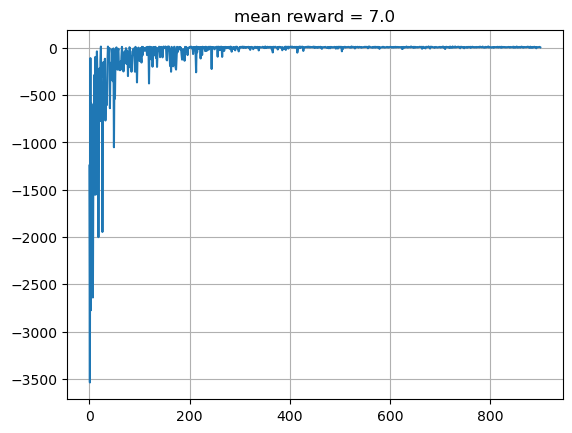

In [7]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))

    if i % 100 == 0:
        clear_output(True)
        plt.title("mean reward = {:.1f}".format(np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.grid()
        plt.show()

## Сохраним видео игры Taxi-v3

In [8]:
import os
from gymnasium.utils.save_video import save_video

env_for_video = gym.make("Taxi-v3", render_mode="rgb_array_list")
n_actions = env_for_video.action_space.n

episode_index = 0
step_starting_index = 0

s, _ = env_for_video.reset()

done = False
frames = []

while not done:
    a = agent.get_action(s)
    next_s, r, done, _, _ = env_for_video.step(a)
    agent.update(s, a, r, next_s)
    s = next_s
    
frames = env_for_video.render()
os.makedirs("videos", exist_ok=True)
save_video(frames, "videos", name_prefix="Taxi", fps=15)

env_for_video.close()


C:\Users\Shurik\anaconda3\envs\ml_1\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


# Discretizer для CartPole

CartPole имеет continuous state space, а Q-learning — табличный.


## Создание среды CartPole

first state: [0.04202272 0.01939759 0.02503605 0.00019182]


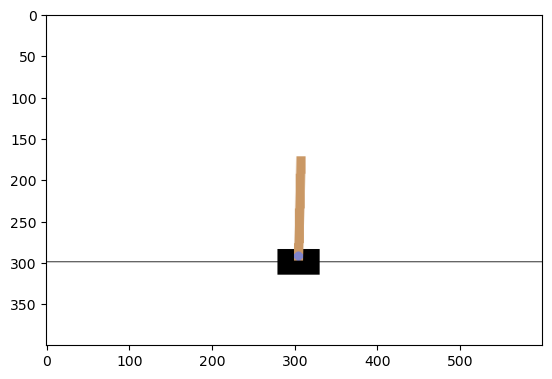

In [34]:
def make_env():
    return gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=2000)


env = make_env()
n_actions = env.action_space.n

print("first state: %s" % (env.reset()[0]))
plt.imshow(env.render())
plt.show()

### Анализ распределения наблюдений
Сыграем несколько игр, чтобы оценить распределение наблюдений

In [35]:
def visualize_cartpole_observation_distribution(seen_observations):
    """
    Строит гистограммы для каждой из 4 переменных состояния CartPole:
    0 — позиция тележки
    1 — скорость тележки
    2 — угол наклона шеста
    3 — скорость конца шеста
    """
    seen_observations = np.array(seen_observations)

    f, axarr = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
    for i, title in enumerate(["Cart Position", "Cart Velocity", "Pole Angle", "Pole Velocity At Tip"]):
        ax = axarr[i // 2, i % 2]
        ax.hist(seen_observations[:, i], bins=20)
        ax.set_title(title)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()

    f.tight_layout()


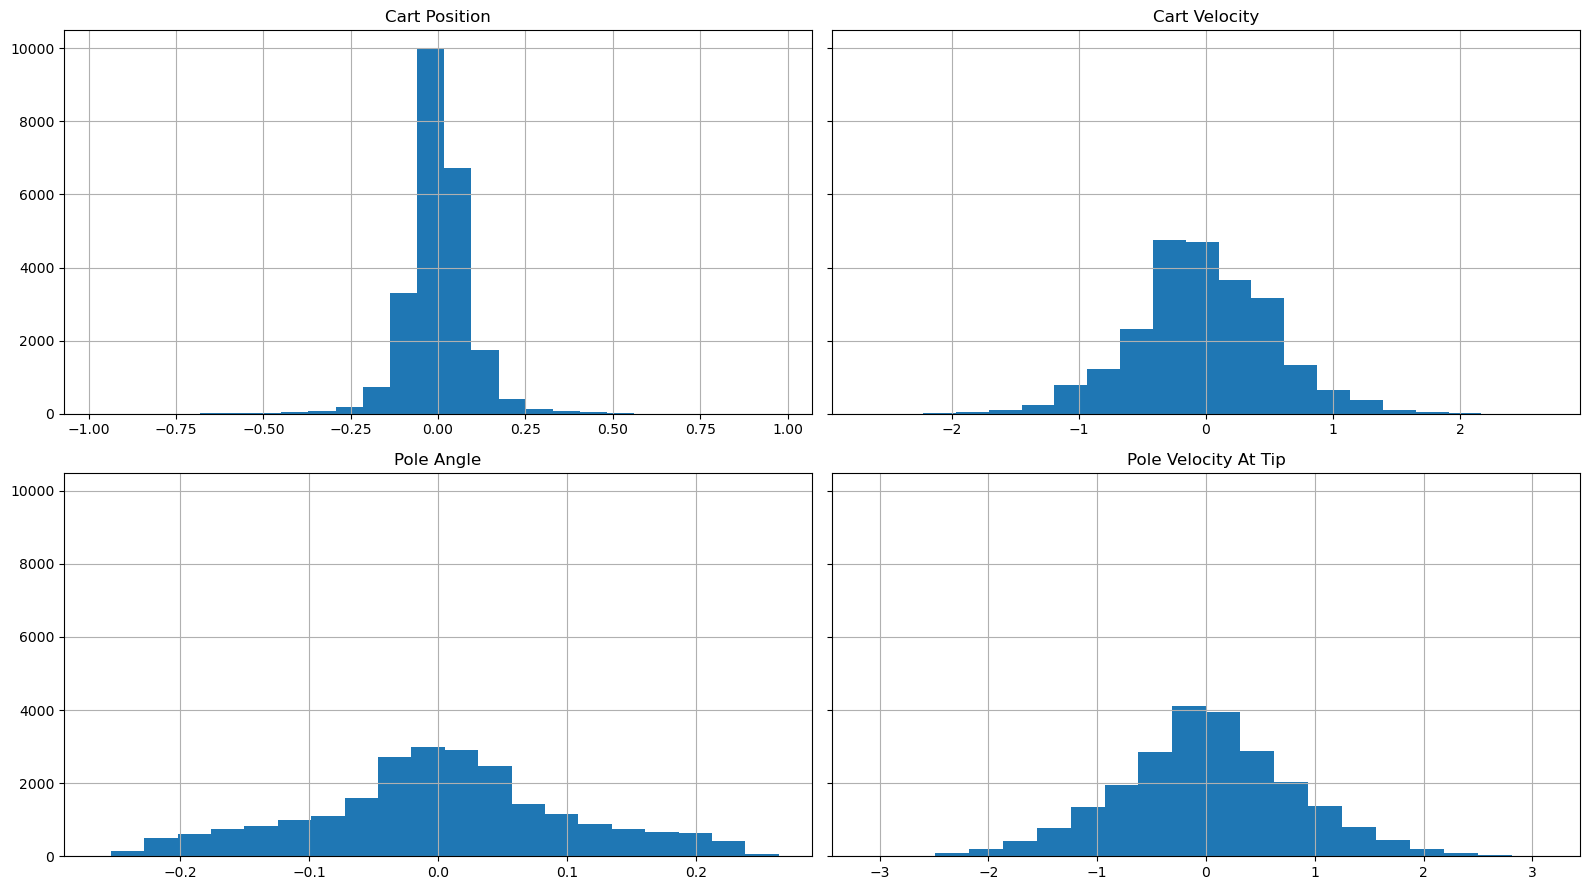

In [36]:
# Собираем случайные состояния для анализа распределения
seen_observations = []
for _ in range(1000):
    s, _ = env.reset()
    seen_observations.append(s)
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)

visualize_cartpole_observation_distribution(seen_observations)

По графикам видно, что дисперсия у Cart Position и Pole Angle меньше, чем у остальных измерений.
Поэтому можно попробовать выделить на них больше знаков после запятой.

## Дискретизация среды

In [37]:
from gymnasium.core import ObservationWrapper


class Discretizer(ObservationWrapper):
    """
    Обёртка среды для дискретизации состояния.
    Каждое измерение состояния округляется до указанного количества знаков.
    """
    def __init__(self, env, ndigits=(2, 1, 2, 1)):
        super().__init__(env)
        self.ndigits = ndigits

    def observation(self, state):
        # Возвращает дискретизированное состояние как кортеж
        return tuple(round(state[i], self.ndigits[i]) for i in range(len(state)))

In [38]:
# Применяем дискретизацию
env = Discretizer(make_env())

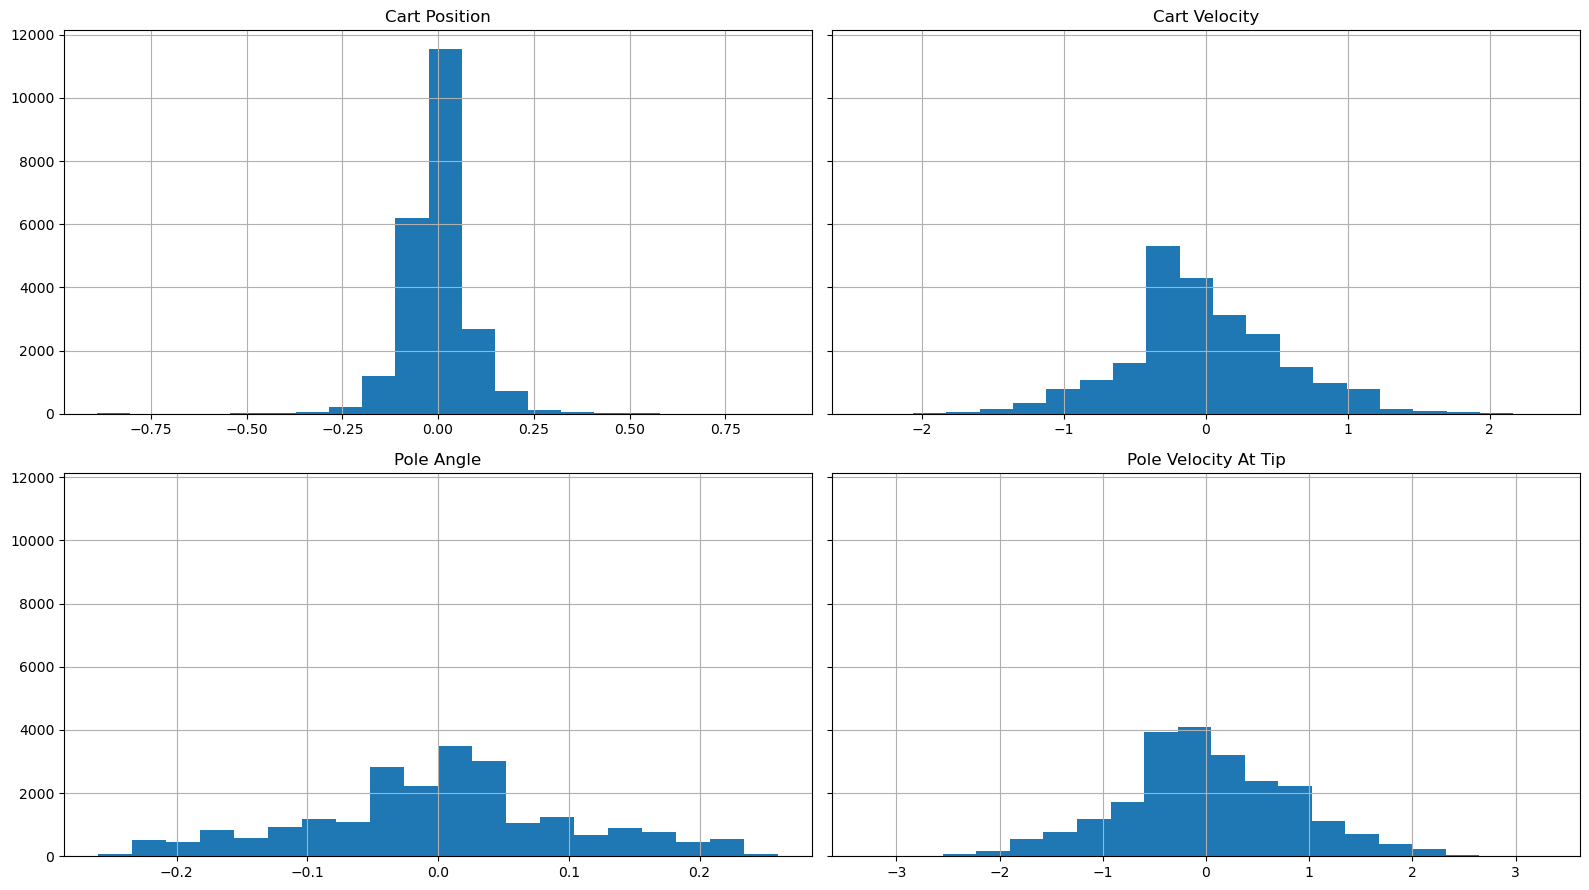

In [39]:
# Проверяем распределение дискретизированных состояний
seen_observations = []
for _ in range(1000):
    s, _ = env.reset()
    seen_observations.append(s)
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)
        if done:
            break

visualize_cartpole_observation_distribution(seen_observations)

## Обучение агента на дискретизированной среде

__Tips:__

- Увеличение количества знаков округления для одной из переменных состояния увеличивает размер пространства состояний примерно в 10 раз.

- Если дискретизация слишком точная (мелкая), агенту потребуется гораздо больше 10000 шагов для сходимости. В таком случае можно либо увеличить число итераций и уменьшить скорость снижения ε, либо изменить дискретизацию. На практике такая ошибка встречается довольно часто.

- Если дискретизация слишком грубая, агент может не найти оптимальную политику. В данной среде это встречается реже, но тоже возможно.

- Начинайте с грубой дискретизации и при необходимости делайте её более точной.

- Рекомендуется иметь примерно 10³–10⁴ различных состояний (len(agent._qvalues)), но это не строгое требование.

- Если обучение не идёт без уменьшения ε (annealing), можно добавить постепенное снижение ε, но убедитесь, что оно не падает слишком быстро.

- Ожидаемый результат: разумный агент должен достигать средней награды не менее 50.

In [40]:
# Скользящее среднее для визуализации награды.
def moving_average(x, span=100):
    return pd.DataFrame({"x": np.asarray(x)}).x.ewm(span=span).mean().values

In [41]:
agent = QLearningAgent(alpha=0.5, discount=0.99, get_legal_actions=lambda s: range(n_actions))
rewards = []

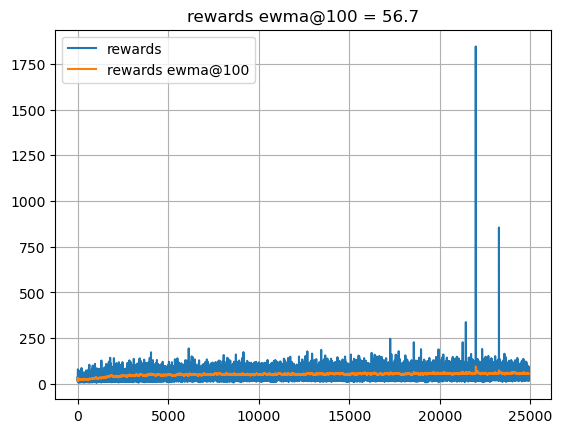

In [44]:
for i in range(20000):
    reward = play_and_train(env, agent)
    rewards.append(reward)

    if i % 100 == 0:
        rewards_ewma = moving_average(rewards)

        clear_output(True)
        plt.plot(rewards, label="rewards")
        plt.plot(rewards_ewma, label="rewards ewma@100")
        plt.legend()
        plt.grid()
        plt.title("rewards ewma@100 = {:.1f}".format(rewards_ewma[-1]))
        plt.show()

In [45]:
print("Your agent has learned {} Q-values.".format(len(agent._qvalues)))

Your agent has learned 159649 Q-values.


## Сохранение видео игры CartPole

In [48]:
video_env = Discretizer(make_env())  # используем ту же дискретизацию
s, _ = video_env.reset()
done = False
frames = []

# Проходим один эпизод с уже обученным агентом
while not done:
    a = agent.get_action(s)
    next_s, r, done, _, _ = video_env.step(a)
    s = next_s
    frames.append(video_env.render())

os.makedirs("videos", exist_ok=True)
save_video(frames, "videos", name_prefix="cartpole_episode", fps=30)

env_for_video.close()

# EV-SARSA with softmax policy

In [50]:
# Импортируем базовый класс QLearningAgent
# и наследуем от него для реализации Expected Value SARSA

class EVSarsaAgent(QLearningAgent):
    """
    Агент, реализующий алгоритм Expected Value SARSA с softmax-политикой.
    
    Отличие от Q-learning: функция get_value() теперь вычисляет
    ожидаемое значение состояния под текущей softmax-политикой:
      V_pi(s) = sum_over_actions pi(a|s) * Q(s, a)

    Остальные методы QLearningAgent без изменений.

    Примечание: update() из QLearningAgent должен использовать get_value(next_state).
    """

    def get_value(self, state):
        
        possible_actions = self.get_legal_actions(state)

        if len(possible_actions) == 0:
            return 0.0

        # Вычисляем вероятности действий по softmax
        probs = self.get_softmax_policy(state)
        # Получаем Q(s, a) для всех возможных действий
        qvalues = [self.get_qvalue(state, action) for action in possible_actions]
        # Считаем ожидаемое значение V(s) = sum(Q * pi)
        value = sum(qvalues * probs)

        return value

Здесь мы расширяем Q-learning до Expected Value SARSA. Основное отличие — в том, что для оценки состояния агент учитывает все возможные действия и их вероятности (softmax), а не только максимальное Q. Это делает стратегию on-policy.

### Cliff World
CliffWalking — классическая среда для тестирования алгоритмов RL, где агент должен добраться до выхода, избегая "обрыва" (cliff). Это позволяет сравнивать поведение on-policy и off-policy алгоритмов.

In [56]:
# Создаём среду "CliffWalking-v1"
env = gym.make("CliffWalking-v1", render_mode="rgb_array")
n_actions = env.action_space.n

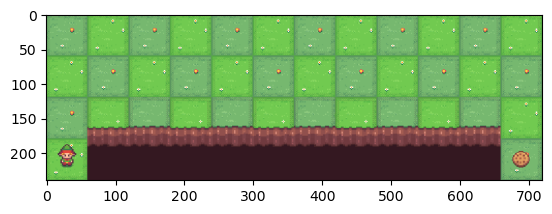

In [57]:
# Визуализируем стартовое состояние

env.reset()
plt.imshow(env.render())
plt.show()

### Инициализация агентов
Используем одинаковые параметры обучения (alpha и discount) для честного сравнения поведения двух алгоритмов.

In [59]:
agent_sarsa = EVSarsaAgent(alpha=0.25, discount=0.99, get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, discount=0.99, get_legal_actions=lambda s: range(n_actions))

### Обучение и визуализация прогресса

EVSARSA mean reward = -19.35
QLEARNING mean reward = -23.9


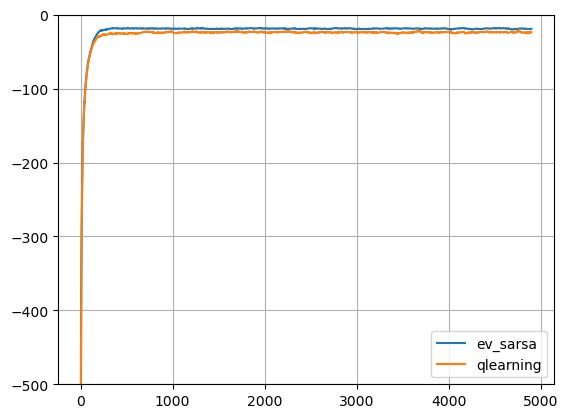

In [60]:
# Функция скользящего среднего для плавного графика

def moving_average(x, span=100):
    return pd.DataFrame({"x": np.asarray(x)}).x.ewm(span=span).mean().values


rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    # Один эпизод обучения для каждого агента
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))

    # Каждые 100 эпизодов визуализируем прогресс
    if i % 100 == 0:
        clear_output(True)
        print("EVSARSA mean reward =", np.mean(rewards_sarsa[-100:]))
        print("QLEARNING mean reward =", np.mean(rewards_ql[-100:]))
        plt.plot(moving_average(rewards_sarsa), label="ev_sarsa")
        plt.plot(moving_average(rewards_ql), label="qlearning")
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

С помощью визуализации политики легко увидеть, какие действия выбирает агент в каждой клетке. Сравнивая Q-learning и EV-SARSA, можно наблюдать разницу между off-policy и on-policy стратегиями

In [67]:
def draw_policy(agent):
    """
    Выводит визуальное представление политики агента в CliffWalking.
    Символы:
        C — обрыв (cliff)
        X — старт
        T — цель
        ^ > v < — направления выбранных действий
    """

    env = gym.make("CliffWalking-v1", render_mode="ansi")
    env.reset()
    grid = [x.split("  ") for x in env.render().split("\n")[:4]]

    n_rows, n_cols = 4, 12
    start_state_index = 36
    actions = "^>v<"

    for yi in range(n_rows):
        for xi in range(n_cols):
            if grid[yi][xi] == "C":
                print(" C ", end="")
            elif (yi * n_cols + xi) == start_state_index:
                print(" X ", end="")
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end="")
            else:
                print(" %s " % actions[agent.get_best_action(yi * n_cols + xi)], end="")
        print()

In [68]:
print("Q-Learning")
draw_policy(agent_ql)

print("SARSA")
draw_policy(agent_sarsa)

Q-Learning
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  v  v  v  v 
 >  >  >  >  >  >  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


В теории EV-SARSA часто безопаснее. Но в данном примере видно, что SARSA выбрала более опасный путь. Вероятно это связано с температурой Softmax.